In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

from panda.utils.plot_utils import (
    apply_custom_style,
    make_clean_projection,
    plot_grid_trajs_multivariate,
    plot_trajs_multivariate,
)

apply_custom_style("../config/plotting.yaml")

/Users/tgut03/GitHub/panda/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model Checkpoint from HF

In [4]:
from panda.patchtst.pipeline import PatchTSTPipeline

pft_model = PatchTSTPipeline.from_pretrained(
    mode="predict",
    pretrain_path="GilpinLab/panda",
    device_map="mps",  # instead of cuda:1
)

/Users/tgut03/GitHub/panda/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Make Trajectory

In [5]:
import dysts.flows as flows  # type: ignore

In [6]:
dyst_name = "QiChen"  # one of the held-out systems not seen during training
sys = getattr(flows, dyst_name)()

In [32]:
num_timesteps = 4096
num_periods = 40

ts, traj = sys.make_trajectory(
    num_timesteps,
    pts_per_period=num_timesteps // num_periods,
    return_times=True,
    atol=1e-10,
    rtol=1e-8,
)
traj.shape

(4096, 8)

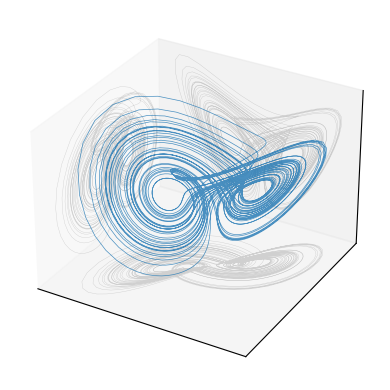

In [9]:
plot_grid_trajs_multivariate(
    {"QiChen": np.expand_dims(traj.T, axis=0)},
    save_path=None,
    sample_indices=[0],
    n_rows_cols=(1, 1),
    subplot_size=(4, 4),
    row_col_padding=(0.0, 0.0),
    plot_kwargs={"linewidth": 0.5, "alpha": 0.8},
    title_kwargs={"fontweight": "bold"},
    show_titles=False,
    show_axes=True,
    plot_projections=True,
    projections_alpha=0.15,
)

### Forecast Trejectory

In [10]:
def plot_model_prediction(
    model,
    context: np.ndarray,
    groundtruth: np.ndarray,
    prediction_length: int,
    title: str | None = None,
    save_path: str | None = None,
    show_plot: bool = True,
    figsize: tuple[int, int] = (6, 8),
    **kwargs,
):
    context_tensor = torch.from_numpy(context.T).float().to(pft_model.device)[None, ...]
    pred = model.predict(context_tensor, prediction_length, **kwargs).squeeze().cpu().numpy()
    total_length = context.shape[1] + prediction_length
    context_ts = np.arange(context.shape[1]) / total_length
    pred_ts = np.arange(context.shape[1], total_length) / total_length

    # Add the last time point of context to the beginning of groundtruth
    # This ensures continuity between context and groundtruth in the plot
    if context.shape[1] > 0 and groundtruth.shape[1] > 0:
        last_context_point = context[:, -1][:, np.newaxis]  # Get last point and reshape to column vector
        groundtruth = np.hstack((last_context_point, groundtruth))  # Prepend to groundtruth

        # Prepend last context point to prediction timeline and data for continuity
        pred_ts = np.concatenate(([context_ts[-1]], pred_ts))
        if pred.shape[0] + 1 == len(pred_ts):
            pred = np.vstack((context[:, -1], pred))

    # Create figure with gridspec layout
    fig = plt.figure(figsize=figsize)

    # Create main grid with padding for colorbar
    outer_grid = fig.add_gridspec(2, 1, height_ratios=[0.65, 0.35], hspace=-0.1)

    # Create sub-grid for the plots
    gs = outer_grid[1].subgridspec(3, 1, height_ratios=[0.2] * 3, wspace=0, hspace=0)
    ax_3d = fig.add_subplot(outer_grid[0], projection="3d")

    ax_3d.plot(*context[:3], alpha=0.5, color="black", label="Context")
    ax_3d.plot(*groundtruth[:3], linestyle="-", color="black", label="Groundtruth")
    ax_3d.plot(*pred.T[:3], color="red", label="Prediction")
    # make_arrow_axes(ax_3d)
    make_clean_projection(ax_3d)

    if title is not None:
        title_name = title.replace("_", " ")
        ax_3d.set_title(title_name, fontweight="bold")

    axes_1d = [fig.add_subplot(gs[i, 0]) for i in range(3)]
    for i, ax in enumerate(axes_1d):
        ax.plot(context_ts, context[i], alpha=0.5, color="black")
        ax.plot(pred_ts, groundtruth[i], linestyle="-", color="black")
        ax.plot(pred_ts, pred[:, i], color="red")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("auto")

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        print(f"saving fig to: {save_path}")
        plt.savefig(save_path, bbox_inches="tight")
    if show_plot:
        plt.show()
    plt.close()

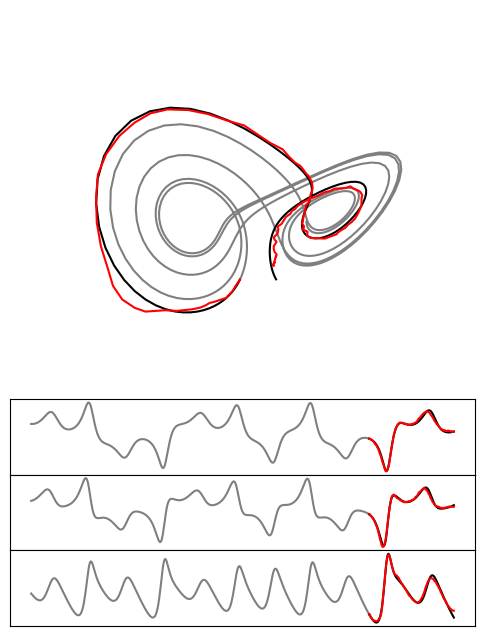

In [11]:
context_length = 512
sample_idx = 0
start_time = 0  # start time of the context window
pred_length = (
    128  # make sure this is a multiple of 128, the prediction length we train for, for autoregressive rollout to work
)
subsample_interval = 1

assert pred_length % 128 == 0, "prediction length must be multiple of 128"

trajectory = traj.T[:, ::subsample_interval]

end_time = start_time + context_length  # end time of context window


plot_model_prediction(
    pft_model,
    trajectory[:, start_time:end_time],  # context
    trajectory[:, end_time : end_time + pred_length],  # ground truth
    pred_length,
    limit_prediction_length=False,
    sliding_context=True,
    save_path=None,
    show_plot=True,
    figsize=(6, 8),
    title=None,
)

### Extra Trajectory of Held-Out Skew System from Saved Parameters

In [29]:
from panda.utils.dyst_utils import init_skew_system_from_params # fix import error ".dyst_utils"

In [33]:
# all of these saved parameters are of held-out skew systems not seen during training
params_dir = "/Users/tgut03/github/panda/assets/params_test_zeroshot"
parameters_json_path_test = os.path.join(params_dir, "filtered_params_dict.json")
saved_params_dict_test = json.load(open(parameters_json_path_test))
saved_params_dict_test.keys()

dict_keys(['Coullet_LorenzStenflo', 'SprottB_YuWang', 'HastingsPowell_LuChenCheng', 'Duffing_LuChenCheng', 'SprottF_HyperYan', 'SprottJ_Duffing', 'Hopfield_HastingsPowell', 'KawczynskiStrizhak_GlycolyticOscillation', 'SprottK_JerkCircuit', 'CircadianRhythm_HindmarshRose', 'YuWang2_LorenzStenflo', 'Duffing_AtmosphericRegime', 'JerkCircuit_ItikBanksTumor', 'HyperYangChen_ChenLee', 'Aizawa_Bouali', 'HastingsPowell_Rossler', 'SprottR_SprottQ', 'HyperJha_CircadianRhythm', 'Halvorsen_Coullet', 'Bouali_SprottQ', 'GlycolyticOscillation_Bouali', 'LuChen_Bouali', 'Bouali_BelousovZhabotinsky', 'Hopfield_SprottI', 'SprottTorus_QiChen', 'SprottF_RikitakeDynamo', 'ForcedBrusselator_ChenLee', 'LorenzStenflo_GuckenheimerHolmes', 'AtmosphericRegime_KawczynskiStrizhak', 'QiChen_Qi', 'Sakarya_MacArthur', 'NuclearQuadrupole_Duffing', 'Bouali2_DoublePendulum', 'Bouali_SaltonSea', 'SprottC_Rossler', 'ChenLee_LorenzStenflo', 'ExcitableCell_KawczynskiStrizhak', 'VallisElNino_Hopfield', 'ArnoldBeltramiChildres

### Make Skew System Trajectory

In [15]:
skew_sys_name = random.choice(list(saved_params_dict_test.keys()))
print(skew_sys_name)

DoubleGyre_Duffing


In [31]:
# Load parameters
skew_sys_params = saved_params_dict_test[skew_sys_name][0]

is_skew = "_" in skew_sys_name
if is_skew:
    driver_name, response_name = skew_sys_name.split("_")
    sys = init_skew_system_from_params(driver_name, response_name, skew_sys_params)
else:
    raise ValueError(f"System {skew_sys_name} is not a skew system")

# Set initial conditions
sys.ic = np.array(skew_sys_params["ic"]) # add initial conditions to skew_system.skew_product.super().__init__()
print(sys.ic)

if not sys.has_jacobian():
    print(f"Jacobian not implemented for {skew_sys_name}")

# Make trajectory
num_timesteps = 4096
num_periods = 40

ts, traj = sys.make_trajectory(
    num_timesteps,
    pts_per_period=num_timesteps // num_periods,
    return_times=True,
    atol=1e-10,
    rtol=1e-8,
)

[1.5401187e+00 5.3707921e+00 4.1054266e+01 1.1619073e+01 2.0040233e+03
 1.3664423e+00 9.3091460e-01 6.4283417e-01]
Jacobian not implemented for CircadianRhythm_Hadley


Showing plot


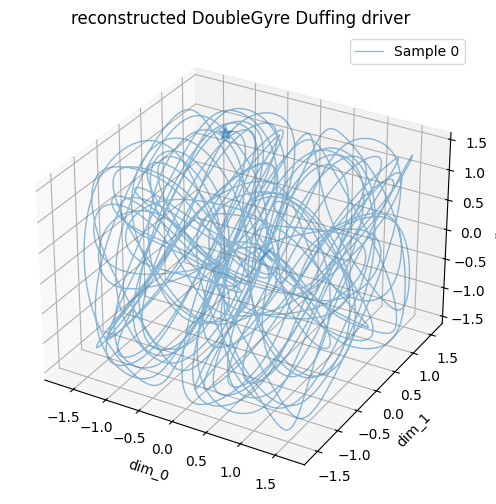

Showing plot


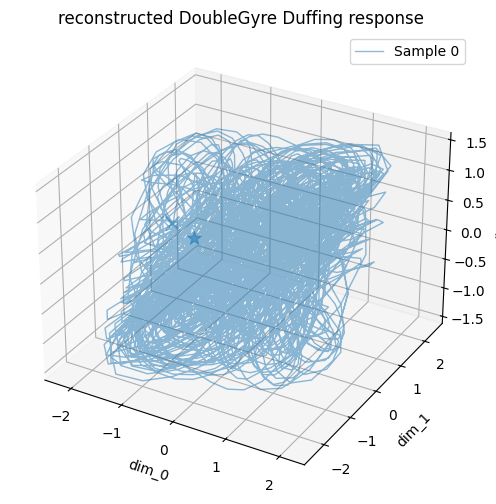

Skew response trajectory shape: (4096, 3)


In [17]:
transient_frac = 0.05
transient_length = int(transient_frac * num_timesteps)

trajectory_to_plot = traj[None, transient_length:, :].transpose(0, 2, 1)
driver_coords = trajectory_to_plot[:, : sys.driver_dim]
response_coords = trajectory_to_plot[:, sys.driver_dim :]
for name, coords in [
    ("driver", driver_coords),
    ("response", response_coords),
]:
    plot_trajs_multivariate(
        coords,
        save_dir=None,
        plot_name=f"reconstructed_{skew_sys_name}_{name}",
        standardize=True,
        plot_projections=False,
        show_plot=True,
    )

skew_response_traj = traj[:, sys.driver_dim :]
print(f"Skew response trajectory shape: {skew_response_traj.shape}")

### Forecast Skew System Trajectory

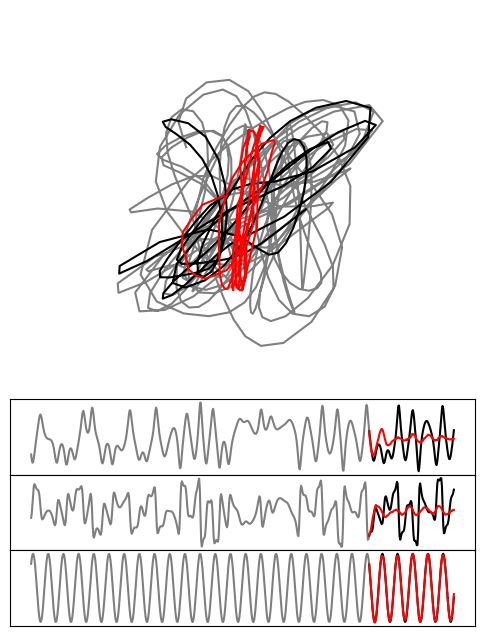

In [18]:
context_length = 512
sample_idx = 0
start_time = 0  # start time of the context window
pred_length = (
    128  # make sure this is a multiple of 128, the prediction length we train for, for autoregressive rollout to work
)
subsample_interval = 1  # NOTE: subsampled by 2x

assert pred_length % 128 == 0, "prediction length must be multiple of 128"

skew_response_trajectory = skew_response_traj.T[:, ::subsample_interval]

end_time = start_time + context_length  # end time of context window


plot_model_prediction(
    pft_model,
    skew_response_trajectory[:, start_time:end_time],  # context
    skew_response_trajectory[:, end_time : end_time + pred_length],  # ground truth
    pred_length,
    limit_prediction_length=False,
    sliding_context=True,
    save_path=None,
    show_plot=True,
    figsize=(6, 8),
    title=None,
)